In [ ]:
import torch
import pandas as pd
import hydra
from omegaconf import DictConfig
from pickle import load
from captum.attr import IntegratedGradients
import numpy as np
import captum
from lstm_model import RegressionLSTM
from transformer.transformer_model import CMIPTimeSeriesDataset
import matplotlib.pyplot as plt

from hydra import initialize, compose
with initialize(version_base=None, config_path="conf"):
    cfg = compose(config_name="config",overrides=['model=lstm'])

model = RegressionLSTM(num_sensors=len(cfg.model.input), hidden_units=cfg.model.hidden_units,cfg=cfg)
model_name = cfg.run_name

checkpoint = torch.load(f'{cfg.project}/checkpoint/lstm_checkpoint_{model_name}.pt')


for key in list(checkpoint['model_state_dict'].keys()):
    checkpoint['model_state_dict'][key.replace('module.', '')] = checkpoint['model_state_dict'].pop(key)

model.load_state_dict(checkpoint['model_state_dict'])

model.eval()

# lrp = LRP(model)
ig = IntegratedGradients(model)
final_input = pd.read_csv(f'{cfg.data}/observed_timeseries30_data.csv')
central_northern_bc = final_input[(final_input['lon'] == -123.75)]
central_manitoba = final_input[(final_input['lon'] == -97.5)]

def getAttribution(input):
    scaler = load(open(f'{cfg.project}/checkpoint/lstm_scaler_{model_name}.pkl', 'rb'))
    input.loc[:,tuple(cfg.model.input)] = scaler.transform(input[cfg.model.input])
    input= input[cfg.model.input + cfg.model.id]
    ds = CMIPTimeSeriesDataset(input,cfg.model.seq_len,len(cfg.model.input) + len(cfg.model.id),cfg)
    input = torch.tensor(ds.data[:1,:,:6]).float()
    attr= ig.attribute(input,target=3) #target 3 is cSoilAbove1m
    return attr.detach().numpy(),ds

# attr_bc,ds_bc = getAttribution(central_northern_bc)
# attr_man,ds_man = getAttribution(central_manitoba)



In [28]:
cm = central_manitoba.groupby(['year','lat','lon']).mean().reset_index().groupby(['year','lon']).mean().reset_index()
cm = cm[cm['year'] < 2014]

In [29]:
cm

,year,lon,lat,ps,tsl,treeFrac,pr,tas_DJF,tas_JJA
0,1984.0,-97.5,52.774869,98763.293945,279.667645,33.761201,0.000020,255.672417,292.059685
1,1985.0,-97.5,52.774869,98806.285156,278.802422,34.141079,0.000020,254.190283,288.625820
2,1986.0,-97.5,52.774869,98807.776367,279.114880,34.535471,0.000019,258.071842,289.776855
3,1987.0,-97.5,52.774869,98810.550781,279.994473,34.209874,0.000017,259.178497,290.698952
4,1988.0,-97.5,52.774869,98750.616211,279.761711,34.214193,0.000016,254.189512,292.729862
5,1989.0,-97.5,52.774869,98883.524414,279.456268,31.059209,0.000016,254.010160,291.797230
6,1990.0,-97.5,52.774869,98658.379883,279.054443,29.230228,0.000018,253.683607,290.852184
7,1991.0,-97.5,52.774869,98752.434570,279.620010,29.385291,0.000019,256.843376,291.929310
8,1992.0,-97.5,52.774869,98816.697266,278.295815,28.945828,0.000017,256.866289,288.148941
9,1993.0,-97.5,52.774869,98804.777344,278.356544,29.711543,0.000019,253.853329,289.353039


In [ ]:
def visualizeAttribution(attr, ds,lat,lon):
    f,ax = plt.subplots(nrows=6,ncols=1,figsize=(10,10))
    plt.xticks(np.arange(0,30, step=1),labels=np.arange(1985, 2015, step=1),rotation=45)
    # plt.xticks(np.arange(1984, 2014, step=1))
    plt.xlabel('Year')
    #cannot take mean of attr bc it is rolling window
    captum.attr.visualization.visualize_timeseries_attr(attr[0,:,:],ds.data[0,:,:6],plt_fig_axis=(f,ax),
                                                    method="overlay_individual",
                                                    channel_labels=['ps','tsl','treeFrac','pr','tas_DJF','tas_JJA'],cmap='Greens',sign='positive', title = f'Latitude = {lat}, Longitude={lon}, Positive Attribution')
    f,ax = plt.subplots(nrows=6,ncols=1,figsize=(10,10))
    # for single_ax in ax:
    #     # single_ax.set_xlim([-1, 1])
    #     single_ax.set_ylim([-2, 2])
    plt.xticks(np.arange(0,30, step=1),labels=np.arange(1985, 2015, step=1),rotation=45)
    # plt.xticks(np.arange(1984, 2014, step=1))
    plt.xlabel('Year')

    captum.attr.visualization.visualize_timeseries_attr(attr[0,:,:],ds.data[0,:,:6],plt_fig_axis=(f,ax),
                                                    method="overlay_individual",
                                                    channel_labels=['ps','tsl','treeFrac','pr','tas_DJF','tas_JJA'],cmap='Reds',sign='negative',title = f'Latitude = {lat}, Longitude={lon}, Negative Attribution')


In [ ]:
central_manitoba = final_input[(final_input['lon'] == -97.5)]
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=1000)
for lat in central_manitoba.lat.unique():
    # fin = central_manitoba[central_manitoba.lat == lat]
    fin = central_manitoba.copy()
    # print(fin.groupby(['lat','year']).mean())
    # print(fin[0:30])
    # print(len(fin))
    attr,ds = getAttribution(fin)
    # print(ds.data[0,:,:6])
    visualizeAttribution(attr,ds,lat = lat,lon= -97.5)
    # break

/Users/gclyne/thesis/env/lib/python3.9/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator StandardScaler from version 1.1.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


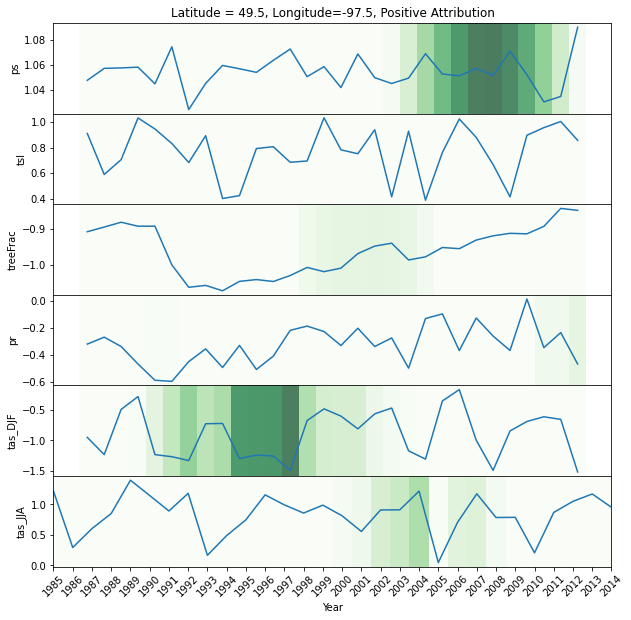

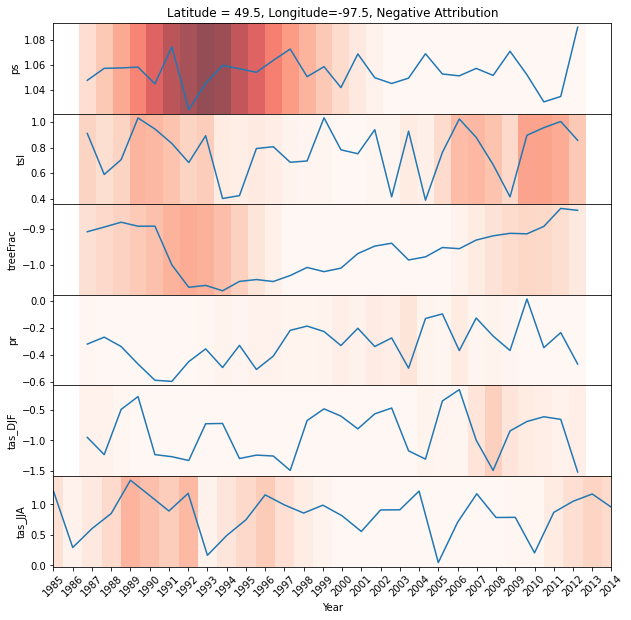

In [31]:
attr,ds = getAttribution(cm[cfg.model.input + cfg.model.id])

visualizeAttribution(attr,ds,lat = 49.5,lon= -97.5)

In [ ]:
central_northern_bc = final_input[(final_input['lon'] == -123.75)]

for lat in central_northern_bc.lat.unique():
    fin = central_northern_bc[central_northern_bc.lat == lat]
    print(len(fin))
    attr,ds = getAttribution(fin)
    print(attr)
    print(ds.data.shape)
    visualizeAttribution(attr,ds,lat = lat,lon= -97.5)
    